### Program written by Scott Midgley, 2021
### Scope: To train and test LR models for band gap energy screening in the configuraional space of MgO-ZnO solid solutions. 

In [1]:
### USER INPUT REQUIRED ###

# Please paste in the path to the repositiory here an comment/uncomment as needed.
# E.g. rundir = r'C:\Users\<user>\Desktop\repository'

# Windows path
#repodir = r'<windows\path\here>'
repodir = r'C:\Users\smidg\Desktop\ml\repository'

#Unix path
#repodir = '<unix/path/here>'

In [2]:
### USER INPUT REQUIRED ###

# Define percentage of training data to use for training. 
split = 10
#split = 50
#split = 80
#split = 30

In [3]:
# Import modules. 
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import pickle
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import os
from sklearn.linear_model import Lasso

In [4]:
# Start program timer.
start_time = time.time()

In [5]:
# Define LR working directory. 
os.chdir(repodir)
os.chdir('coulomb_matrix')
os.chdir('lr')
os.chdir('EMIX')
lrdir = os.getcwd()
print(lrdir)

C:\Users\smidg\Desktop\ml\repository\coulomb_matrix\lr\EMIX


In [6]:
# Import data and shuffle (optional).
os.chdir('..')
os.chdir('..')
os.chdir('data')
os.chdir('rundir')
eners = pd.read_pickle('input_data.pkl')
#eners = eners.sample(frac=1)
os.chdir(lrdir)

In [7]:
# Calculate mixing energies based on total DFT energy of phase separated end members. Add emix to data frame.  
Emg_end = -381.17925146/32
Ezn_end = -317.49620269/36
Emg_end = 24 * Emg_end
Ezn_end = 8 * Ezn_end
emix = eners['SCF Energy'] - (Emg_end + Ezn_end)
eners['Emix'] = emix

In [8]:
# Split data frame into training, validation, and testing data. 
if split == int(10):
    e_train = eners.iloc[1608:2412] #10% of data for training
elif split == int(30):
    e_train = eners.iloc[1608:4021] #30% of data for training
elif split == int(50):
    e_train = eners.iloc[1608:5630] #50% of data for training
elif split == int(80):
    e_train = eners.iloc[1608:] #80% of data for training
else:
    print('Error: please choose a valid train/test split.')
e_val = eners.iloc[804:1608] #10% of data for validation
e_test = eners.iloc[:804] #10% of data for testing model

In [9]:
# Convert Pandas columns to Numpy arrays. Reshaping to obtain array of nested brackets. 
Xtrain = e_train['Coulomb'].to_numpy()
ytrain = e_train['Emix'].to_numpy()
Xtrain = np.stack(Xtrain)
ytrain= np.stack(ytrain) 
Xval = e_val['Coulomb'].to_numpy()
yval = e_val['Emix'].to_numpy()
Xval = np.stack(Xval)
yval= np.stack(yval)
Xtest = e_test['Coulomb'].to_numpy()
ytest = e_test['Emix'].to_numpy()
Xtest = np.stack(Xtest)
ytest = np.stack(ytest)

In [10]:
# Define Lasso regularizer and train regressor.
lasso_reg = Lasso(alpha=0.0000001)
lasso_reg.fit(Xtrain, ytrain)

C:\Users\smidg\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009612887781714275, tolerance: 9.18566193168657e-05
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=1e-07)

In [11]:
# Print parameters.
r_sq = (lasso_reg.score(Xtrain, ytrain))
inter = ('intercept: ', lasso_reg.intercept_)
coef = ('coefficient:  ', lasso_reg.coef_)
print(r_sq)
print(inter)
print(coef)

0.9980841763722073
('intercept: ', 4.752227016679519)
('coefficient:  ', array([ 1.49135153e-03,  1.50737932e-04,  6.44208958e-05,  9.10932712e-06,
       -2.72251882e-05, -4.43132266e-05, -7.95208060e-05, -1.23584746e-04,
       -7.63204842e-04,  2.10959575e-03,  2.18870759e-03,  2.38414563e-03,
        2.50753282e-03,  2.61204065e-03,  2.67152439e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  8.04248923e-04,
        7.77446012e-04,  9.27234245e-04, -5.95020789e-04, -1.65936188e-03,
       -1.63537691e-03, -1.64143263e-03, -1.80410699e-03, -2.16931428e-03,
       -2.41846366e-03, -2.70809484e-03, -3.02614020e-03, -3.31904624e-03,
        7.23542221e-03,  2.72282293e-02,  3.17578807e-02,  3.33153538e-02,
        3.23881612e-02,  3.10344263e-02,  3.10431389e-02,  3.15656286e-02,
        2.59338730e-02,  1.01003149e-01,  0.00000000e+00, -8.09413477e-03,
        1.05624004e-04, -6.03827989e-03, -5.64437899e-03, -1.55206139e-02,
       -2.52664445e-02, -3.

In [12]:
# Test linear regressor.
ypred = lasso_reg.predict(Xtest)

In [13]:
# Print metric.
mae = (mean_absolute_error(ytest, ypred))
print('mae = ', mae)

mae =  0.001143755468132883


Text(0, 0.5, 'Regressor')

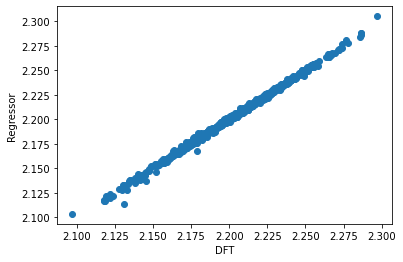

In [14]:
#Plot DFT mixing energy vs regressor predicted.
plt.scatter(ytest, ypred)# plot the predicted versus the actual gaps
plt.xlabel('DFT')
plt.ylabel('Regressor')
#plt.savefig('BGE_pred_vs_val.png')

In [15]:
### Data export
df_data = pd.DataFrame()
df_data['ytest'] = ytest
df_data['ypred'] = ypred
metrics_df = pd.DataFrame()
metrics_df['metrics'] = mae, r_sq

result = pd.concat([df_data, metrics_df], axis=1)
result.to_excel('result.xlsx')

In [16]:
# Print time taken by program to run. 
time_s = round((time.time() - start_time), 2)
time_m = round((time_s/60), 2)
print(time_s,'sec')
print(time_m, 'min')

0.81 sec
0.01 min
